# Simple Model - Debug

In [1]:
from __future__ import print_function, division
from IPython.core.display import display, HTML
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from multiprocessing import Pool
cosmology.setCosmology('WMAP9')

import numpy as np
import pandas as pd
import emcee
import pandas as pd
import time
import os
import sys
from scipy.optimize import minimize
import scipy.stats
import math
import matplotlib.pyplot as plt
import pylab as plt
import corner

from colossus.cosmology import cosmology
cosmology.setCosmology('WMAP9')

In [2]:
%matplotlib inline

In [3]:
def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_chisi(zeta, xi):
    res = np.exp(-(xi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res

def prob_lbd_hat(x, mean , std):
    res = gaussian(x, mean , std)
    return res

def prob_mass(zeta, mass, z, params):
    params = A_sze, B_sze, C_sze, scatter_sze
    ln_zeta_pred = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, z)
    ln_prob = -0.5*((np.log(zeta)-ln_zeta_pred)/scatter_sze)**2
    return ln_prob
    
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,1)
    return ilo, iup

In [4]:
def log_likelihood_simple(theta, indices, eps=1e-9):
    # for each cluster compute the log_likelihood
    
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_likelihood_simple(theta, ix))
        #What will occur with this break??
        #break
    
    # missing a normalization factor
    p = np.array(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [5]:
def _likelihood_simple(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling the indepedent variables
    # there are defined as global variables
    mass_i = mass[ix]
    redshift_i = redshift[ix]
    p_chisi = prob_chisi_vec[ix]
    p_lbd_hat = prob_lbd_hat_vec[ix]
    
    # take the indices with non zero values for P_chisi, P_lbd_hat
    # this approx. makes the code to run faster by a factor 10
    llo, lup = list(lbd_indices_vec[ix])

    #llo, lup = 0, len(lbdvec)
    clo, cup = list(zeta_indices_vec[ix])

    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass_i, redshift_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass_i, redshift_i)
    
    # the logNormal Distribution
    lp_lbd_zeta = compute_log_pLbdZeta(ll[clo:cup,llo:lup], zz[clo:cup,llo:lup],
                                      scatter_lambda, scatter_sze, rho,
                                      ln_lbd_pred, ln_zeta_pred)
    
    p_lbd_zeta = np.exp(lp_lbd_zeta)
    
    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)

    # integrate over lambda
    norm = np.trapz(p_lbd, x=lbdvec[llo:lup])
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    return p/norm

In [6]:
def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    
    lp += 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = -1.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp += 0. if (theta_values[-1] > 0) else -np.inf
    return lp

In [7]:
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

In [8]:
#### DEFINING THE FUNCTION PRIOR ####

SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

## gaussian priors on lambda with 3 sigma from the true params
Lambda_Priors = {'A_lambda':[76.9, 3*8.2], 'B_lambda':[1.020, 5*0.080],'C_lambda':[0.23, 5*0.16],
             'scatter_lambda':[0.23, 3.0*0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']


def logprior(theta):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho >= -1.) and (rho <= 1.)) else -np.inf
    return lp + lp_lambda + lp_sze

In [9]:
def logposterior(theta, indices):
    lp = logprior(theta)
    # print("This is the value of the logprior : ", lp)
    if not np.isfinite(lp):
        return -np.inf, -np.inf
    
    ll = log_likelihood_simple(theta, indices)# + lp
    if not np.isfinite(ll):
        return lp, -np.inf
    return lp + ll, lp

In [10]:
def compute_log_pLbdZeta(Lambda, Zeta, scatter_lambda, scatter_sze, rho,
                         ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    s_zeta = scatter_sze
    s_lambda = scatter_lambda
    s_lambda_inv = np.where(s_lambda<=eps, np.inf, 1/s_lambda)
    s_zeta_inv = np.where(s_zeta<=eps, np.inf, 1/s_zeta)
    
    # avoid error messages
    rho2 = (1-rho**2)
    rho_inv = np.where(rho2<=eps, np.inf, 1/rho2)
    cov2 = (s_lambda)**(2)*(s_zeta)**(2)*rho2
    
    additional_cov = (-0.5)*np.log(np.pi*cov2)

    lbd_std = (np.log(Lambda) - ln_lbd_pred)*s_lambda_inv
    zeta_std = (np.log(Zeta) - ln_zeta_pred)*s_zeta_inv

    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2.

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2.

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std
    
    # total likelihood
    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov

    return lp_total_m

In [11]:
### Grid Setting
nCores = 32
Nzeta = 100
Nlbd = 200
Nmass = 150
Nz = 100
alpha = 0.001

### MCMC Setup
theta_true = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]
Nburnin = 1000 # number of burn-in samples
Nsamples = 50000 # number of final posterior samples
walkers = 64
ndims = len(theta_true)
guess = (np.array(theta_true)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# global variables
M0 = 3e14
Ez0 = E(0)

## For Fake Data

In [12]:
### CURRENT FAKE DATA FILE ###
infile = 'fake_data_Jul4.csv'

df = pd.read_csv(infile)
mask = (df['lambda']>2.)&(df['zeta']>0.)
ix = np.where(mask)[0]
Np = ix.size

# Set Variables
indices = np.arange(Np,dtype=int)
yerr = 0.05*(df['lambda'].to_numpy())
redshift = (np.array(df['z']))[ix]
zeta = (np.array(df['zeta']))[ix]
sz_signal = (np.array(df['chisi']))[ix]
_lambda = (np.array(df['lambda_wo_noise']))[ix]
_lambda_error = (np.array(yerr))[ix]
mass = np.array(df['M'])[ix]

In [13]:
# set up integration vectors
zvec = np.linspace(np.min(redshift), np.max(redshift), Nz)
mvec = np.logspace(13.8, 15.2, Nmass)
lbdvec = np.linspace(0.8*np.min(_lambda), 1.2*np.max(_lambda), Nlbd)
zetavec = np.linspace(1.5, 1.2*np.max(zeta), Nzeta)
zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

print('Vector size')
print('lambda vec',lbdvec.size)
print('zeta vec',zetavec.size)
print('mass vec',mvec.size)
print('Number of points',Np)

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])

print("This is prob_lbd_hat_vec shape: ", prob_lbd_hat_vec.shape)
print("This is lbd_indices_vec: ", lbd_indices_vec[:3])
print("This is zeta_indices_vec shape: ", zeta_indices_vec.shape)

Vector size
lambda vec 200
zeta vec 100
mass vec 150
Number of points 1318
This is prob_lbd_hat_vec shape:  (1318, 200)
This is lbd_indices_vec:  [[15 26]
 [45 67]
 [ 6 14]]
This is zeta_indices_vec shape:  (1318, 2)


In [14]:
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]
logposterior(theta_true, sel)
print("The value of the logposterior using theta_true and sel: ", logposterior(theta_true, sel))
indices = np.arange(len(mass))
print("The value of the logposterior using theta_true and indices (STANDARD): ", logposterior(theta_true, indices))

The value of the logposterior using theta_true and sel:  (-299.94695680095805, -0.013446180555555555)
The value of the logposterior using theta_true and indices (STANDARD):  (-3962.001099352232, -0.013446180555555555)


In [ ]:
# ## TEMPORARILY FOR TESTING ADDITIONAL ANALYSIS METHODS ##
# #### BRINGING IN THE HALO MASS FUNCTION ####
# def _halo_mass_function(M, z):
#     return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')

# halo_mass_function = np.vectorize(_halo_mass_function)

In [ ]:
# #### AGAIN A BROADCASTING ISSUE IS NOT ALLOWING ME TO TEST USING THIS METHOD ####

# ## TESTING ZZ AND LL INSTEAD OF MM AND ZZ SINCE MM IS NEVER USED IN THE SIMPLE
# ## MODEL IMPLEMENTATION AS WE ASSUME THE VALUE OF THE MASS AND IT IS NOT NECESSARY TO USE
# ## UNLIKE THE SPT MODEL WHICH DOES NOT ASSUME THE VALUE OF THE MASS


# # Restating the original declaration from above for clarity
# zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

# A_lambda, B_lambda, C_lambda, scatter_lambda = theta_true[4:8]
# A_sze, B_sze, C_sze, scatter_sze = theta_true[:4]
# rho = theta_true[-1]

# mass_i = mass[ix]
# redshift_i = redshift[ix]
# p_chisi = prob_chisi_vec[ix]
# p_lbd_hat = prob_lbd_hat_vec[ix]

#  # take the indices with non zero values for P_chisi, P_lbd_hat
# # this approx. makes the code to run faster by a factor 10

# for x, y in list(lbd_indices_vec[ix]):
#     llo, lup = x, y

# #llo, lup = 0, len(lbdvec)
# for x, y in list(zeta_indices_vec[ix]):
#     clo, cup = x, y

# # calling predictions;
# ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass_i, redshift_i)
# ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass_i, redshift_i)
 
# # the logNormal Distribution
# lp_lbd_zeta = compute_log_pLbdZeta(ll[clo:cup,llo:lup], zz[clo:cup,llo:lup],
#                                       scatter_lambda, scatter_sze, rho,
#                                       ln_lbd_pred, ln_zeta_pred)
    
# p_lbd_zeta = np.exp(lp_lbd_zeta)
    
# # integrate over zeta
# p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
# p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)

# # integrate over lambda
# norm = np.trapz(p_lbd, x=lbdvec[llo:lup])
# p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)

# ln_lbd_pred_new = (ln_lbd_pred).T
# ln_zeta_pred_new = (ln_zeta_pred).T

Simple Model took 212.9 seconds
Maximum likelihood estimates:
Albd = 84.922
Blbd = 0.819
Clbd = 0.247
Scatter_lbd = 0.208
rho: 0.877
lps: [3962.001099352232, 3956.0462250082815]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289, 3959.559780065367]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289, 3959.559780065367, 4001.54287797479]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289, 3959.559780065367, 4001.54287797479, 4029.1211139486795]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289, 3959.559780065367, 4001.54287797479, 4029.1211139486795, 5054.574241071175]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289, 3959.559780065367, 4001.54287797479, 4029.1211139486795, 5054.574241071175, 4191.785242420965]
lps: [3962.001099352232, 3956.0462250082815, 3993.005565099289, 3959.559780065367, 4001.54287797479, 4029.1211139486795, 5054.574241071175, 4191.785242420

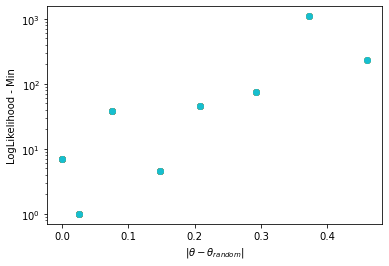

In [15]:
### QUICK FIT ###
start = time.time()
np.random.seed(42)
nll = lambda *args: -logposterior(*args)[0]
initial = theta_true + 0.05 * np.random.randn(9)
## Gives a small amount of uncertainty to the values of theta_true since
## they are already known
soln = minimize(nll, initial, args=indices)
end = time.time()
sp_time = end - start
print("Simple Model took {0:.1f} seconds".format(sp_time))

albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))
    
initial = theta_true + 0.1 * np.random.randn(9)
logposterior(initial,indices)
    
## plotting this results
t0 = time.time()
np.random.seed(42)
lps = [-1.*logposterior(theta_true,indices)[0]]
dist = [0.]
# increase the quick from the truth
for i in [1.,2.5,5.,7.5,10.,15.,20.,25.,30.,60]:
    initial = theta_true + (i/100.) * np.random.randn(9)
    #print(1-np.array(initial)/np.array(theta_true))
    nDist = np.linalg.norm(np.array(theta_true)-np.array(initial))
    lps.append(-1.*logposterior(initial,indices)[0])
    dist.append(nDist)
        
    print("lps:", lps)
    
    plt.scatter(dist,np.array(lps)-np.min(lps)+1.)
    plt.ylabel('LogLikelihood - Min')
    plt.xlabel(r'|$\theta-\theta_{random}$|')
    plt.yscale('log')

In [ ]:
### MCMC RUN ###

print('Starting MCMC')
pool = Pool(processes=nCores)              # start 64 worker processes
backend = emcee.backends.HDFBackend(filename)
backend.reset(walkers, ndims)
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=[indices], backend=backend, pool=pool)
start = time.time()
sampler.run_mcmc(guess, Nsamples+Nburnin)
end = time.time()
sp_mcmc_time = end - start
print("SPT Model took {0:.1f} seconds".format(sp_mcmc_time))
#print("It is {} slower than the very simple model".format(sp_mcmc_time/vsp_mcmc_time))

flat_samples = sampler.flatchain
np.save(filename[:-2], flat_samples)

## For Real Data

In [16]:
### CURRENT REAL DATA FILE ###
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
ix = np.where(data['LAMBDA_CHISQ']>30)[0]
Np = ix.size

# Set Variables
indices = np.arange(Np,dtype=int)
sz_signal = np.array(data['XI'])[ix]
zeta = np.sqrt(sz_signal**2-3)
_lambda = np.array(data['LAMBDA_CHISQ'])[ix]
_lambda_error = np.array(data['LAMBDA_CHISQ_E'])[ix]
redshift = np.array(data['REDSHIFT'])[ix]
mass = np.array(data['M500']*1e14)[ix]

In [17]:
# set up integration vectors
zvec = np.linspace(np.min(redshift), np.max(redshift), Nz)
mvec = np.logspace(13.8, 15.2, Nmass)
lbdvec = np.linspace(0.8*np.min(_lambda), 1.2*np.max(_lambda), Nlbd)
zetavec = np.linspace(1.5, 1.2*np.max(zeta), Nzeta)
zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')


print('Vector size')
print('lambda vec',lbdvec.size)
print('zeta vec',zetavec.size)
print('mass vec',mvec.size)
print('Number of points',Np)

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])

print("This is prob_lbd_hat_vec shape: ", prob_lbd_hat_vec.shape)
print("This is lbd_indices_vec: ", lbd_indices_vec[:3])
print("This is zeta_indices_vec shape: ", zeta_indices_vec.shape)

Vector size
lambda vec 200
zeta vec 100
mass vec 150
Number of points 266
This is prob_lbd_hat_vec shape:  (266, 200)
This is lbd_indices_vec:  [[42 69]
 [59 86]
 [29 59]]
This is zeta_indices_vec shape:  (266, 2)


In [18]:
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]
logposterior(theta_true, sel)
print("The value of the logposterior using theta_true and sel: ", logposterior(theta_true, sel))
indices = np.arange(len(mass))
print("The value of the logposterior using theta_true and indicies (STANDARD): ", logposterior(theta_true, indices))

The value of the logposterior using theta_true and sel:  (-407.60427638646576, -0.013446180555555555)
The value of the logposterior using theta_true and indicies (STANDARD):  (-1060.6125860921456, -0.013446180555555555)


In [ ]:
# ## sz_signal is the equivalent of what was previously called chisi_i
# ## but the operands do not want to broadcast
# p_chisi = prob_chisi(zetavec, sz_signal)
# p_lbd_hat = prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i)

# p_chisi = np.tile(p_chisi, (len(lbdvec), 1)).T

# # integrate over zeta
# p_lbd = simps(p_lbd_zeta*p_chisi, x=zetavec, axis=0)

# # integrate over zeta
# p = simps(p_lbd*p_lbd_hat, x=lbdvec, axis=0)


# doNorm = lambda x: x/np.sum(x)
# plt.xscale('log')
# plt.scatter(lbdvec, doNorm(p_lbd),label='dn_lbd_zeta')
# plt.scatter(lbdvec, doNorm(p_lbd_hat),label='prob_chisi')
# plt.scatter(lbdvec, doNorm(p_lbd_hat*p_lbd),color='k',label='prob_chisi x dn_lbd_zeta')
# plt.legend(fontsize=12)
# plt.xlabel('lambda',fontsize=14)

Simple Model took 109.6 seconds
Maximum likelihood estimates:
Albd = 66.174
Blbd = 1.072
Clbd = -0.180
Scatter_lbd = 0.458
rho: 0.142
lps: [1060.6125860921456, 1048.4012398461684]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533, 1034.1396790437666]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533, 1034.1396790437666, 967.3387214157175]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533, 1034.1396790437666, 967.3387214157175, 1169.6985237491256]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533, 1034.1396790437666, 967.3387214157175, 1169.6985237491256, 1537.3749224491114]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533, 1034.1396790437666, 967.3387214157175, 1169.6985237491256, 1537.3749224491114, 1145.267081418366]
lps: [1060.6125860921456, 1048.4012398461684, 1124.4970127773533, 1034.1396790437666, 967.3387214157175, 1169.6985237491256, 1537

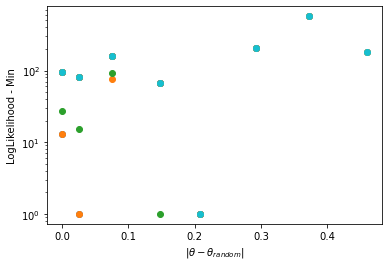

In [19]:
### QUICK FIT ###
start = time.time()
np.random.seed(42)
nll = lambda *args: -logposterior(*args)[0]
initial = theta_true + 0.05 * np.random.randn(9)
## Gives a small amount of uncertainty to the values of theta_true since
## they are already known
soln = minimize(nll, initial, args=indices)
end = time.time()
sp_time = end - start
print("Simple Model took {0:.1f} seconds".format(sp_time))

albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))
    
initial = theta_true + 0.1 * np.random.randn(9)
logposterior(initial,indices)
    
## plotting this results
t0 = time.time()
np.random.seed(42)
lps = [-1.*logposterior(theta_true,indices)[0]]
dist = [0.]
# increase the quick from the truth
for i in [1.,2.5,5.,7.5,10.,15.,20.,25.,30.,60]:
    initial = theta_true + (i/100.) * np.random.randn(9)
    #print(1-np.array(initial)/np.array(theta_true))
    nDist = np.linalg.norm(np.array(theta_true)-np.array(initial))
    lps.append(-1.*logposterior(initial,indices)[0])
    dist.append(nDist)
        
    print("lps:", lps)
    
    plt.scatter(dist,np.array(lps)-np.min(lps)+1.)
    plt.ylabel('LogLikelihood - Min')
    plt.xlabel(r'|$\theta-\theta_{random}$|')
    plt.yscale('log')

In [ ]:
### MCMC RUN ###

print('Starting MCMC')
pool = Pool(processes=nCores)              # start 64 worker processes
backend = emcee.backends.HDFBackend(filename)
backend.reset(walkers, ndims)
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=[indices], backend=backend, pool=pool)
start = time.time()
sampler.run_mcmc(guess, Nsamples+Nburnin)
end = time.time()
sp_mcmc_time = end - start
print("SPT Model took {0:.1f} seconds".format(sp_mcmc_time))
#print("It is {} slower than the very simple model".format(sp_mcmc_time/vsp_mcmc_time))

flat_samples = sampler.flatchain
np.save(filename[:-2], flat_samples)